# NOTEBOOK BINARY ML: MACHINE LEARNING BINARY CLASSIFICATION

## 1. OBJECTIVES

This notebook aims to perform binary classification (Attack vs Normal traffic) using classical machine learning models. It will serve as a baseline to compare with LLM-based methods later in the project.

## 2. IMPORTS AND SETUP
Import the required python libraries, preprocessing, model training, and evaluation.

In [1]:
# numpy and pandas imports
import numpy as np
import pandas as pd
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
# models imports
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
import lightgbm as lgb
# sklearn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

## 3. DATA LOADING
Load the EdgeIIoT dataset and filter it to retain only binary class samples (e.g., “Normal” vs “Attack”).

In [2]:
# Read dataset
csv_path = "../data/DNN-EdgeIIoT-dataset.csv"
df = pd.read_csv(csv_path,low_memory=False)
df.head()

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,2021 11:44:10.081753000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
1,2021 11:44:10.162218000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,4.0,MQTT,0,0.0,4.0,0.0,0.0,0.0,0,Normal
2,2021 11:44:10.162271000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
3,2021 11:44:10.162641000,192.168.0.128,192.168.0.101,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0,Normal
4,2021 11:44:10.166132000,192.168.0.101,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,Temperature_and_Humidity,24.0,0.0,0.0,0.0,0.0,0,Normal


In [3]:
# print columns
print(df.columns)

Index(['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
       'arp.opcode', 'arp.hw.size', 'arp.src.proto_ipv4', 'icmp.checksum',
       'icmp.seq_le', 'icmp.transmit_timestamp', 'icmp.unused',
       'http.file_data', 'http.content_length', 'http.request.uri.query',
       'http.request.method', 'http.referer', 'http.request.full_uri',
       'http.request.version', 'http.response', 'http.tls_port', 'tcp.ack',
       'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin',
       'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack',
       'tcp.dstport', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'tcp.options',
       'tcp.payload', 'tcp.seq', 'tcp.srcport', 'udp.port', 'udp.stream',
       'udp.time_delta', 'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu',
       'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request',
       'dns.retransmit_request_in', 'mqtt.conack.flags',
       'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len

In [4]:
# Save a backup of the dataframe
df_bp = df

## 4. FEATURE SELECTION AND PREPROCESSING
- Select the most important features based on prior analysis (e.g., feature importance from RandomForest).
- Encode categorical features if necessary.
- Normalize/scale the feature values.

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
# Check for missing values
df.isna().sum()

frame.time                   0
ip.src_host                  0
ip.dst_host                  0
arp.dst.proto_ipv4           0
arp.opcode                   0
arp.hw.size                  0
arp.src.proto_ipv4           0
icmp.checksum                0
icmp.seq_le                  0
icmp.transmit_timestamp      0
icmp.unused                  0
http.file_data               0
http.content_length          0
http.request.uri.query       0
http.request.method          0
http.referer                 0
http.request.full_uri        0
http.request.version         0
http.response                0
http.tls_port                0
tcp.ack                      0
tcp.ack_raw                  0
tcp.checksum                 0
tcp.connection.fin           0
tcp.connection.rst           0
tcp.connection.syn           0
tcp.connection.synack        0
tcp.dstport                  0
tcp.flags                    0
tcp.flags.ack                0
tcp.len                      0
tcp.options                  0
tcp.payl

### 4.1. FEATURE SELECTION

We use a random forest classifier to select the best 7 features.

dns.qry.name.len     0.205840
mqtt.protoname       0.138802
mqtt.msg             0.109687
mqtt.topic           0.101408
mqtt.conack.flags    0.095618
tcp.options          0.081726
tcp.dstport          0.055727
dtype: float64


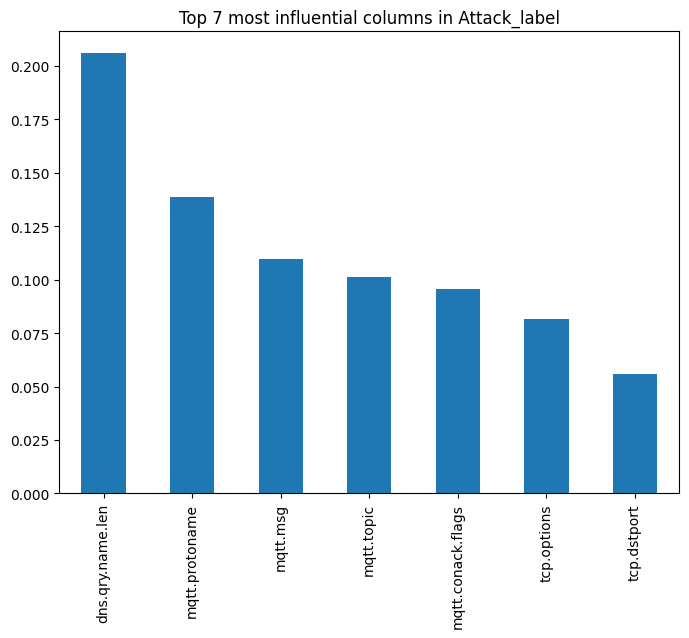

In [7]:
# Convert Attack_label to an integer (0 or 1)
df["Attack_label"] = df["Attack_label"].astype(int)

# Remove unnecessary columns
df = df.drop(["frame.time", "Attack_type"], axis=1, errors="ignore")

# Convert categorical variables into numerical values
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Separate features and target variable
X = df.drop(columns=["Attack_label"])
y = df["Attack_label"]

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the top 15 most influential features
print(feature_importance.head(7))

# Plot feature importance
plt.figure(figsize=(8,6))
feature_importance.head(7).plot(kind="bar")
plt.title("Top 7 most influential columns in Attack_label")
plt.show()

In [8]:
# Define the selected columns
selected_columns = [
    "dns.qry.name.len", "mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags",
    "tcp.options", "tcp.dstport"
]

# Filter the dataset to keep only these columns + target variable
df_selected = df_bp[selected_columns + ["Attack_label"]]

In [9]:
df_selected.head()

,dns.qry.name.len,mqtt.protoname,mqtt.msg,mqtt.topic,mqtt.conack.flags,tcp.options,tcp.dstport,Attack_label
0,0,0,0,0,0,020405b40101040201030307,64855.0,0
1,0,MQTT,0,0,0,0,1883.0,0
2,0,0,0,0,0,0,64855.0,0
3,0,0,0,0,0x00000000,0,64855.0,0
4,0,0,32342e36382037362e34320d0a,Temperature_and_Humidity,0,0,1883.0,0


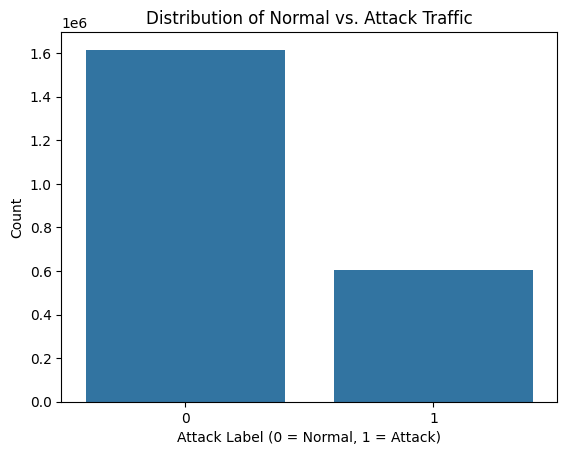

In [10]:
# Count occurrences of each class
sns.countplot(x=df_selected["Attack_label"])
plt.title("Distribution of Normal vs. Attack Traffic")
plt.xlabel("Attack Label (0 = Normal, 1 = Attack)")
plt.ylabel("Count")
plt.show()

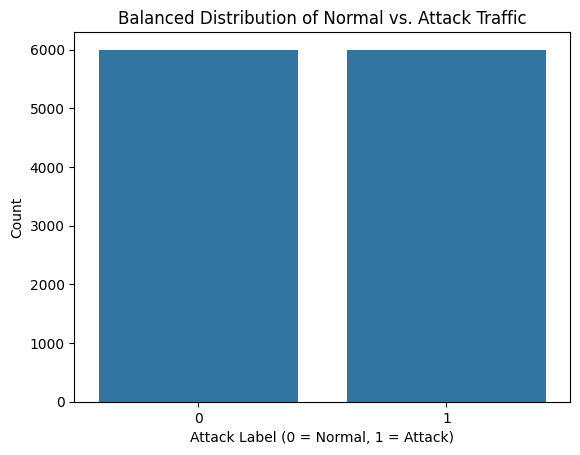

In [11]:
# 6000 samples of normal traffic and 6000 samples of attack traffic - 12k samples in total
df_attack = df_selected[df_selected["Attack_label"] == 1].sample(n=6000, random_state=42)
df_normal = df_selected[df_selected["Attack_label"] == 0].sample(n=6000, random_state=42)

# Concat both
df_balanced = pd.concat([df_attack, df_normal]).sample(frac=1, random_state=42)

sns.countplot(x=df_balanced["Attack_label"])
plt.title("Balanced Distribution of Normal vs. Attack Traffic")
plt.xlabel("Attack Label (0 = Normal, 1 = Attack)")
plt.ylabel("Count")
plt.show()

### 4.2. FEATURE PREPROCESSING

Apply one-hot encoding for the categorical columns.

In [12]:
# Columns to One-Hot Encode
categorical_columns = ["dns.qry.name.len","mqtt.protoname", "mqtt.msg", "mqtt.topic", "mqtt.conack.flags", "tcp.options"]

# Apply One-Hot Encoding
df_encoded = pd.get_dummies(df_balanced, columns=categorical_columns, drop_first=True)

print(df_encoded.head())


         tcp.dstport  Attack_label  dns.qry.name.len_0.0  \
2135750          0.0             1                  True   
93541        54700.0             0                 False   
1957796          0.0             1                  True   
133814       57390.0             0                 False   
1889242         80.0             1                  True   

         dns.qry.name.len_0.debian.pool.ntp.org  dns.qry.name.len_1.0  \
2135750                                   False                 False   
93541                                     False                 False   
1957796                                   False                 False   
133814                                    False                 False   
1889242                                   False                 False   

         dns.qry.name.len_2.debian.pool.ntp.org  mqtt.protoname_0.0  \
2135750                                   False                True   
93541                                     False           

In [13]:
y = df_encoded["Attack_label"] 
X = df_encoded.drop(columns=["Attack_label"]) 

## 5. TRAIN AND TEST SPLIT
Split data in 70% train, 15% validation and 15% test.

In [14]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

## 6. MODELS TRAINING AND EVALUATION


### 6.1. RANDOM FOREST

In [15]:
# Train the model with the training set
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model performance on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="weighted")
val_recall = recall_score(y_val, y_val_pred, average="weighted")
val_f1 = f1_score(y_val, y_val_pred, average="weighted")

print("Validation - Binary evaluation results (RandomForest):")
print(f" - Accuracy: {val_accuracy:.4f}")
print(f" - Precision: {val_precision:.4f}")
print(f" - Recall: {val_recall:.4f}")
print(f" - F1-score: {val_f1:.4f}")

# Evaluate model performance on the test set
y_pred_RF = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_RF)
test_precision = precision_score(y_test, y_pred_RF, average="weighted")
test_recall = recall_score(y_test, y_pred_RF, average="weighted")
test_f1 = f1_score(y_test, y_pred_RF, average="weighted")

print("\nTest - Binary evaluation results (RandomForest):")
print(f" - Accuracy: {test_accuracy:.4f}")
print(f" - Precision: {test_precision:.4f}")
print(f" - Recall: {test_recall:.4f}")
print(f" - F1-score: {test_f1:.4f}")

Validation - Binary evaluation results (RandomForest):
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-score: 1.0000

Test - Binary evaluation results (RandomForest):
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-score: 1.0000


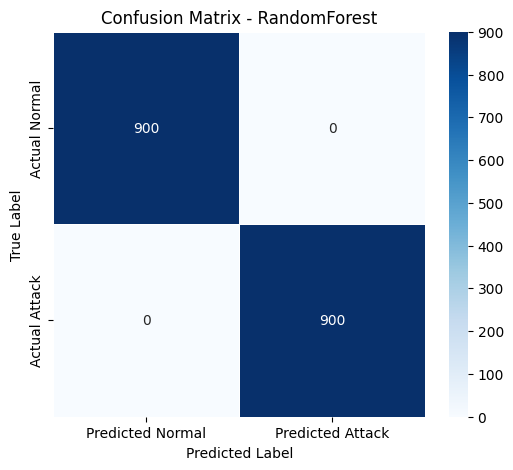

In [16]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_RF)

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual Normal", "Actual Attack"], columns=["Predicted Normal", "Predicted Attack"])

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - RandomForest")
plt.show()

### 6.2. XGBOOST

In [17]:
# Train the model with the training set
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)
model.fit(X_train, y_train)

# Evaluate model performance on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="weighted")
val_recall = recall_score(y_val, y_val_pred, average="weighted")
val_f1 = f1_score(y_val, y_val_pred, average="weighted")

print("Validation - Binary evaluation results (XGBoost):")
print(f" - Accuracy: {val_accuracy:.4f}")
print(f" - Precision: {val_precision:.4f}")
print(f" - Recall: {val_recall:.4f}")
print(f" - F1-score: {val_f1:.4f}")

# Evaluate model performance on the test set
y_pred_xg = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_xg)
test_precision = precision_score(y_test, y_pred_xg, average="weighted")
test_recall = recall_score(y_test, y_pred_xg, average="weighted")
test_f1 = f1_score(y_test, y_pred_xg, average="weighted")

print("\nTest - Binary evaluation results (XGBoost):")
print(f" - Accuracy: {test_accuracy:.4f}")
print(f" - Precision: {test_precision:.4f}")
print(f" - Recall: {test_recall:.4f}")
print(f" - F1-score: {test_f1:.4f}")

Validation - Binary evaluation results (XGBoost):
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-score: 1.0000

Test - Binary evaluation results (XGBoost):
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-score: 1.0000


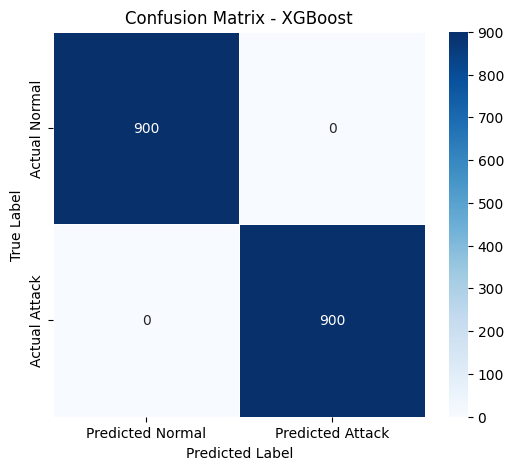

In [18]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_xg)

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual Normal", "Actual Attack"], columns=["Predicted Normal", "Predicted Attack"])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

### 6.3. LIGHTBM

In [19]:
# Train the model with the training set
model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=-1,
    learning_rate=0.05,
    num_leaves=50,
    min_data_in_leaf=10,
    subsample=0.7,
    colsample_bytree=0.7,
    class_weight="balanced",
    random_state=42,
    verbose=-1
)

model.fit(X_train, y_train)

# Evaluate model performance on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="weighted")
val_recall = recall_score(y_val, y_val_pred, average="weighted")
val_f1 = f1_score(y_val, y_val_pred, average="weighted")

print("Validation - Binary evaluation results (LightGBM):")
print(f" - Accuracy: {val_accuracy:.4f}")
print(f" - Precision: {val_precision:.4f}")
print(f" - Recall: {val_recall:.4f}")
print(f" - F1-score: {val_f1:.4f}")

# Evaluate model performance on the test set
y_pred_lgbm = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_lgbm)
test_precision = precision_score(y_test, y_pred_lgbm, average="weighted")
test_recall = recall_score(y_test, y_pred_lgbm, average="weighted")
test_f1 = f1_score(y_test, y_pred_lgbm, average="weighted")

print("\nTest - Binary evaluation results (LightGBM):")
print(f" - Accuracy: {test_accuracy:.4f}")
print(f" - Precision: {test_precision:.4f}")
print(f" - Recall: {test_recall:.4f}")
print(f" - F1-score: {test_f1:.4f}")

Validation - Binary evaluation results (LightGBM):
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-score: 1.0000

Test - Binary evaluation results (LightGBM):
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-score: 1.0000


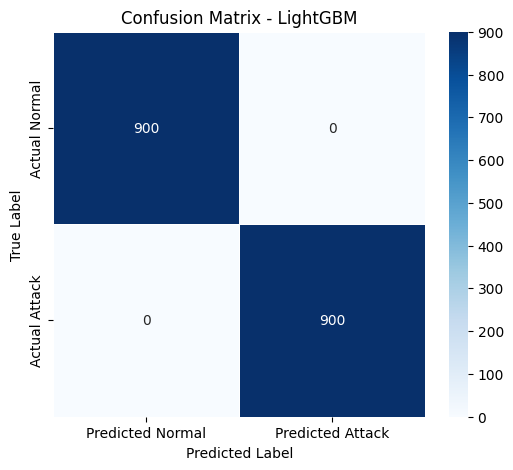

In [20]:
# Compute the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lgbm)

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual Normal", "Actual Attack"], columns=["Predicted Normal", "Predicted Attack"])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LightGBM")
plt.show()

### 6.4. MLP

In [21]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [22]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)

        self.layer2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)

        self.layer3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)

        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)
        return torch.sigmoid(self.output_layer(x))

In [23]:
# Convert data to PyTorch tensors
def to_tensor(X, y):
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y.to_numpy(), dtype=torch.float32).unsqueeze(1)

X_train_tensor, y_train_tensor = to_tensor(X_train, y_train)
X_val_tensor, y_val_tensor = to_tensor(X_val, y_val)
X_test_tensor, y_test_tensor = to_tensor(X_test, y_test)

# Initialize the model, loss function, optimizer and train
input_dim = X_train.shape[1]
model = MLP(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
#  Train the model
epochs = 100
batch_size = 64

for epoch in range(epochs):
    model.train()
    for i in range(0, X_train_tensor.shape[0], batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 10/100, Loss: 0.0009
Epoch 20/100, Loss: 0.0002
Epoch 30/100, Loss: 0.0001
Epoch 40/100, Loss: 0.0000
Epoch 50/100, Loss: 0.0000
Epoch 60/100, Loss: 0.0003
Epoch 70/100, Loss: 0.0002
Epoch 80/100, Loss: 0.0000
Epoch 90/100, Loss: 0.0000
Epoch 100/100, Loss: 0.0000


In [25]:
# Evaluate model performance on the validation set
model.eval()
with torch.no_grad():
    y_val_pred = (model(X_val_tensor) >= 0.5).int().numpy().flatten()

val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="weighted", zero_division=0)
val_recall = recall_score(y_val, y_val_pred, average="weighted", zero_division=0)
val_f1 = f1_score(y_val, y_val_pred, average="weighted", zero_division=0)

print("Validation - Binary evaluation results (MLP):")
print(f" - Accuracy: {val_accuracy:.4f}")
print(f" - Precision: {val_precision:.4f}")
print(f" - Recall: {val_recall:.4f}")
print(f" - F1-score: {val_f1:.4f}")

# Evaluate model performance on the test set
with torch.no_grad():
    y_pred_mlp = (model(X_test_tensor) >= 0.5).int().numpy().flatten()

test_accuracy = accuracy_score(y_test, y_pred_mlp)
test_precision = precision_score(y_test, y_pred_mlp, average="weighted", zero_division=0)
test_recall = recall_score(y_test, y_pred_mlp, average="weighted", zero_division=0)
test_f1 = f1_score(y_test, y_pred_mlp, average="weighted", zero_division=0)

print("\nTest - Binary evaluation results (MLP):")
print(f" - Accuracy: {test_accuracy:.4f}")
print(f" - Precision: {test_precision:.4f}")
print(f" - Recall: {test_recall:.4f}")
print(f" - F1-score: {test_f1:.4f}")

Validation - Binary evaluation results (MLP):
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-score: 1.0000

Test - Binary evaluation results (MLP):
 - Accuracy: 1.0000
 - Precision: 1.0000
 - Recall: 1.0000
 - F1-score: 1.0000


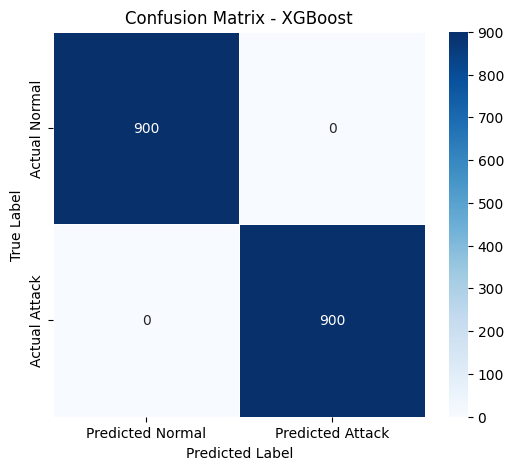

In [26]:
# Compute the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_mlp)

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual Normal", "Actual Attack"], columns=["Predicted Normal", "Predicted Attack"])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

## 7. RESULTS COMPARISON

In [27]:
# Function to compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred, average="weighted"),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted")
    }

# Calculate metrics
metrics_mlp = compute_metrics(y_test, y_pred_mlp)
metrics_xgb = compute_metrics(y_test, y_pred_xg)
metrics_lgbm = compute_metrics(y_test, y_pred_lgbm)
metrics_rf = compute_metrics(y_test, y_pred_RF)

# Create dataframe
metrics_comparison_df = pd.DataFrame({
    "MLP": metrics_mlp,
    "XGBoost": metrics_xgb,
    "LightGBM": metrics_lgbm,
    "RandomForest": metrics_rf,
}).T  

# Show table with the comparison of metrics
print(metrics_comparison_df)

              Accuracy  F1 Score  Precision  Recall
MLP                1.0       1.0        1.0     1.0
XGBoost            1.0       1.0        1.0     1.0
LightGBM           1.0       1.0        1.0     1.0
RandomForest       1.0       1.0        1.0     1.0
